In [1]:
import pandas as pd
import numpy as np

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

In [4]:
!wget $data -O 'course.csv'

--2025-10-19 12:34:52--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course.csv’

course.csv          100%[===================>]  78.98K  --.-KB/s    in 0.03s   

2025-10-19 12:34:53 (2.33 MB/s) - ‘course.csv’ saved [80876/80876]



In [227]:
df = pd.read_csv('course.csv')

In [228]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [229]:
df.columns

Index(['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income',
       'employment_status', 'location', 'interaction_count', 'lead_score',
       'converted'],
      dtype='object')

In [33]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [230]:
categorical= list(df.dtypes[df.dtypes=='object'].index)

In [231]:
categorical

['lead_source', 'industry', 'employment_status', 'location']

In [232]:
numerical= list(df.dtypes[df.dtypes!='object'].index)

In [233]:
numerical.remove("converted")

In [234]:
numerical

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score']

In [235]:
for c in categorical:
    df[c] = df[c].str.lower().str.replace(' ','_')

In [236]:
df[numerical].isna().sum()

number_of_courses_viewed      0
annual_income               181
interaction_count             0
lead_score                    0
dtype: int64

In [237]:
for c in categorical:
    df[c] = df[c].fillna('NA')

In [238]:
for c in numerical:
    df[c] = df[c].fillna(0)

In [239]:
from sklearn.model_selection import train_test_split

In [240]:
df_full_train, df_test = train_test_split(df,test_size=0.2,random_state=1)

In [241]:
df_train, df_val=train_test_split(df_full_train,test_size=0.25,random_state=1)

In [242]:
len(df), len(df_train), len(df_test), len(df_val)

(1462, 876, 293, 293)

In [243]:
y_full_train = df_full_train.converted.values
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

In [244]:
len(y_full_train), len(y_train), len(y_val), len(y_test)

(1169, 876, 293, 293)

In [245]:
del df_full_train['converted']
del df_train['converted']
del df_val['converted']
del df_test['converted']

In [186]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score

In [187]:
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

LogisticRegression(max_iter=1000, solver='liblinear')

In [188]:
dv = DictVectorizer()

train_dict = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [189]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [190]:
y_pred_val = model.predict_proba(X_val)[:,1]

In [191]:
y_val.mean().sum()

0.5836177474402731

In [192]:
y_pred_val.mean().sum()

0.6022654399995111

In [193]:
convert_decision = (y_pred_val >= 0.5).astype(int)

In [194]:
df_pred = pd.DataFrame()
df_pred['actual']=y_val
df_pred['probability']=y_pred_val
df_pred['prediction']=convert_decision.astype(int)

In [195]:
df_pred['correct'] = df_pred.prediction == df_pred.actual

In [196]:
df_pred['correct'].mean()

0.6177474402730375

In [110]:
accuracy = accuracy_score(y_val,convert_decision)
accuracy

0.6177474402730375

In [127]:
total_true = np.sum(convert_decision)
total_false = (len(convert_decision) - np.sum(convert_decision))
len(convert_decision), total_true, total_false, total_true/len(convert_decision)


(293, 199, 94, 0.6791808873720137)

In [ ]:
from collections import Counter

In [197]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
t = 0.5
predict_positive = (y_pred_val >= t)
predict_negative = (y_pred_val < t)
sum(actual_positive), sum(actual_negative), sum(predict_positive), sum(predict_negative)

(171, 122, 199, 94)

In [198]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [199]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[ 52,  70],
       [ 42, 129]])

In [200]:
p = tp / (tp + fp)
p

0.6482412060301508

In [201]:
r = tp / (tp + fn)
r

0.7543859649122807

In [202]:
tpr = tp / (tp + fn)
tpr

0.7543859649122807

In [148]:
fpr = fp / (fp + tn)
fpr

0.5737704918032787

In [150]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred_val >= t)
    predict_negative = (y_pred_val < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [151]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [153]:
import matplotlib.pyplot as plt

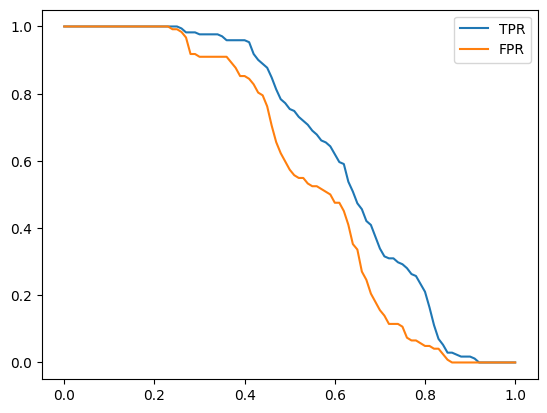

In [154]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

In [203]:
from sklearn.metrics import auc

In [204]:
from sklearn.metrics import roc_curve

In [205]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_val)

In [206]:
auc(fpr, tpr)

0.6344310229124724

In [163]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [169]:
numerical

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score',
 'converted']

In [164]:
def createDict(field):
    dv = DictVectorizer()

    train_dict = df_train[field].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    val_dict = df_val[field].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    return X_train, y_train, X_val

In [165]:
def returnPredictions(X_train, y_train, X_val):
    model.fit(X_train, y_train)
    y_pred_val = model.predict_proba(X_val)[:,1]
    return y_val, y_pred_val

In [166]:
def returnAuc(y_val, y_pred_val):
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_val)
    area =auc(fpr, tpr)
    return area

In [182]:
numerical

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score']

In [307]:
from sklearn.metrics import roc_auc_score, classification_report

In [290]:
def returnAucScore(y_val, y_pred_val):
    score = roc_auc_score(y_val, y_pred_val)
    return score

In [215]:
#Question 1
for c in numerical:
    area= returnAucScore(y_train,df_train[c].values)
    print("Category : %s Area : %s", c, area)

Category : %s Area : %s number_of_courses_viewed 0.7635680590007088
Category : %s Area : %s annual_income 0.5519578313253012
Category : %s Area : %s interaction_count 0.738270176293409
Category : %s Area : %s lead_score 0.6144993577250176


In [ ]:
#Question #2

In [265]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score

In [267]:
dv = DictVectorizer()

#full_train_dict = df_full_train.to_dict(orient='records')
#X_full_train = dv.fit_transform(full_train_dict)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [268]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [269]:
y_pred_val = model.predict_proba(X_val)[:,1]

In [276]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
t = 0.5
predict_positive = (y_pred_val >= t)
predict_negative = (y_pred_val < t)
sum(actual_positive), sum(actual_negative), sum(predict_positive), sum(predict_negative)

(171, 122, 245, 48)

In [277]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[ 41,  81],
       [  7, 164]])

In [278]:
p = tp / (tp + fp)
r = tp / (tp + fn)
p, r

(0.6693877551020408, 0.9590643274853801)

In [282]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred_val >= t)
    predict_negative = (y_pred_val < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [283]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

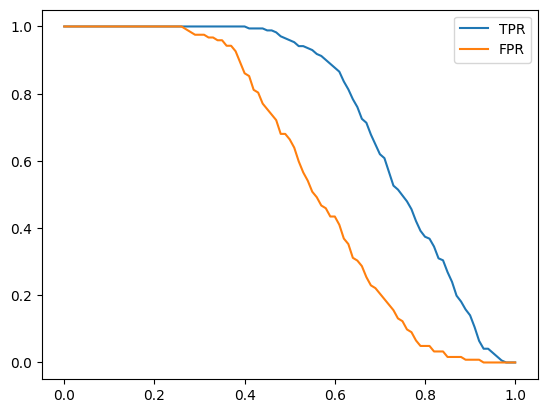

In [284]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

In [287]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [285]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(122, 171)

In [286]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

y_ideal_pred = np.linspace(0, 1, len(y_val))

In [288]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

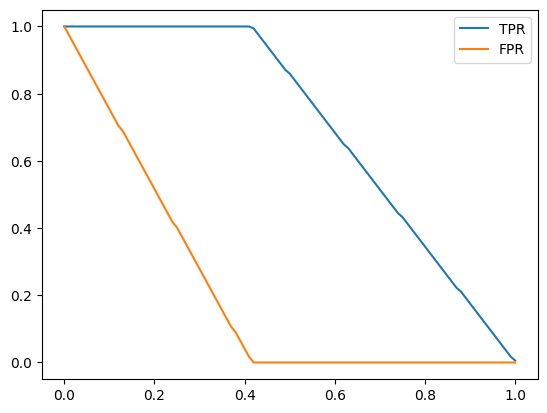

In [289]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

In [304]:
auc_ideal = returnAucScore(y_ideal, convert_ideal_decision)
auc_ideal

0.9298245614035088

In [310]:
convert_decision = (y_pred_val >= 0.5).astype(int)

In [311]:
fpr, tpr, thresholds = roc_curve(y_val, convert_decision)

In [314]:
auc_score = returnAucScore(y_val, y_pred_val)
auc_score

0.8171316268814112

In [224]:
target_names = ['class 0', 'class 1']
print(classification_report(y_val, convert_decision, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.55      0.43      0.48       122
     class 1       0.65      0.75      0.70       171

    accuracy                           0.62       293
   macro avg       0.60      0.59      0.59       293
weighted avg       0.61      0.62      0.61       293



In [258]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_val, convert_decision, average='binary')
recall = recall_score(y_val, convert_decision, average='binary')
f1 = f1_score(y_val, convert_decision, average='binary')
precision,recall, f1

(0.680672268907563, 0.9473684210526315, 0.7921760391198044)

In [315]:
df_val_pred = tpr_fpr_dataframe(y_val, y_pred_val)

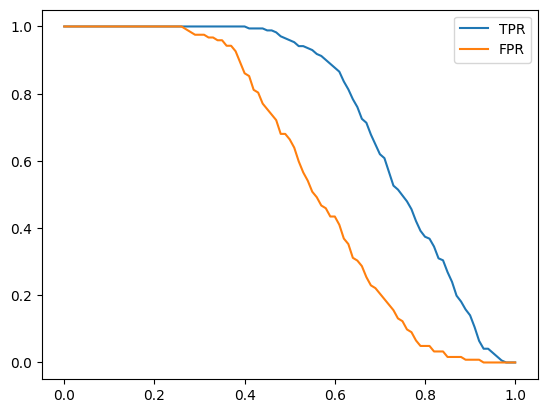

In [316]:
plt.plot(df_val_pred.threshold, df_val_pred['tpr'], label='TPR')
plt.plot(df_val_pred.threshold, df_val_pred['fpr'], label='FPR')
plt.legend()

In [318]:
from sklearn.metrics import auc

In [319]:
auc(df_val_pred.fpr, df_val_pred.tpr)

0.8161969130476464

In [322]:
auc(fpr, tpr)

0.647564950627936